# Clustering with KMeans

In [1]:
#Data manipulation and analysis
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Statistical Analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 160)
pd.set_option('display.max_colwidth', 30)

In [2]:
#Loading data from notebook 02 eda
df = pd.read_csv("/Users/dan/PycharmProjects/Arsenal-Striker-Scouting/data/filtered_striker_df.csv")
df.head()

,Unnamed: 0,name,position,nation,age,club,league,mins_played,ninety_mins_played,goals_scored,penalty_goals,non_pen_exp_goals,exp_goals,assists,exp_assists,total_shots,shots_on_target,goals_per_shot,goals_per_sot,shot_on_target_perc,avg_shot_distance,key_passes,shot_creation_per_90,goal_creation_per_90,pass_completion_perc,progressive_carries,total_carries,total_touches,touches_in_attacking_third,touches_in_pen,progressive_runs,times_dispossessed,passes_received,aerial_duels_won,aerial_duels_lost,aerial_duel_win_perc,tackles,tackles_and_interceptions,goals_per_ninety,exp_goals_per_ninety,goals_minus_exp_goals
0,0,Abdallah Sima,"FW,MF",sn SEN,23.0,Brest,fr Ligue 1,1238,13.8,7,0,5.9,5.9,2,1.0,37,18,0.189189,0.388889,48.648649,13.1,13,2.04,0.22,69.6,36,299,510,8,66,92,22,378,41,7,85.416667,15,16,0.507246,0.427536,1.1
1,4,Adam Hložek,"FW,MF",cz CZE,22.0,Hoffenheim,de Bundesliga,1871,20.8,8,0,5.6,5.6,4,3.5,59,24,0.135593,0.333333,40.677966,17.3,20,2.74,0.48,68.5,54,429,761,7,114,102,37,552,40,9,81.632653,22,26,0.384615,0.269231,2.4
2,7,Ademola Lookman,"MF,FW",ng NGA,27.0,Atalanta,it Serie A,2247,25.0,15,1,9.5,10.3,5,7.1,81,32,0.185185,0.468750,39.506173,14.7,61,5.41,0.60,72.5,142,827,1274,8,199,316,51,974,17,8,68.000000,32,35,0.600000,0.412000,4.7
3,14,Alassane Pléa,"MF,FW",fr FRA,32.0,Gladbach,de Bundesliga,1902,21.1,11,1,6.6,7.4,4,3.1,41,12,0.268293,0.916667,29.268293,15.2,25,3.41,0.66,72.1,51,601,979,5,77,141,22,773,15,9,62.500000,7,9,0.521327,0.350711,3.6
4,16,Albert Guðmundsson,"FW,MF",is ISL,27.0,Fiorentina,it Serie A,1273,14.1,6,2,3.1,4.7,1,1.8,25,13,0.240000,0.461538,52.000000,20.6,15,2.76,0.35,83.0,35,402,624,3,32,59,14,466,4,10,28.571429,9,15,0.425532,0.333333,1.3


In [3]:
#Dropping rogue column :)
df = df.drop(columns=['Unnamed: 0'])

In [4]:
#Checking the shape of the dataframe
df.shape

(216, 40)

### Feature selection

In [5]:
#Defining features for modelling
feature_selection = df[[
    "progressive_runs", "touches_in_pen", "aerial_duels_won", "shots_on_target",
    "goals_per_sot", "goals_minus_exp_goals", "goals_per_ninety", "non_pen_exp_goals",
    "exp_assists", "age"
]]

### KMeans v1

In [6]:
#Scaling the features
scaler_mm = MinMaxScaler()
X_scaled_mm = scaler_mm.fit_transform(feature_selection)

#Store in DataFrame with feature names for better interpretability
X_scaled_mm_df = pd.DataFrame(X_scaled_mm, columns=feature_selection.columns)

In [7]:
#KMeans using feature selection
k_values_select = range(2, 11)
silhouette_scores = []
inertia = []

for k in k_values_select:
    kmeans_select = KMeans(n_clusters=k, random_state=8, init='k-means++', n_init=10, max_iter=300)
    cluster_labels = kmeans_select.fit_predict(X_scaled_mm)

    #Storing Silhouette Score
    silhouette_scores.append(silhouette_score(X_scaled_mm, cluster_labels))

#Finding optimal k using silhouette score
optimal_k = k_values_select[np.argmax(silhouette_scores)]
print(f"Optimal K:", optimal_k)

Optimal K: 5


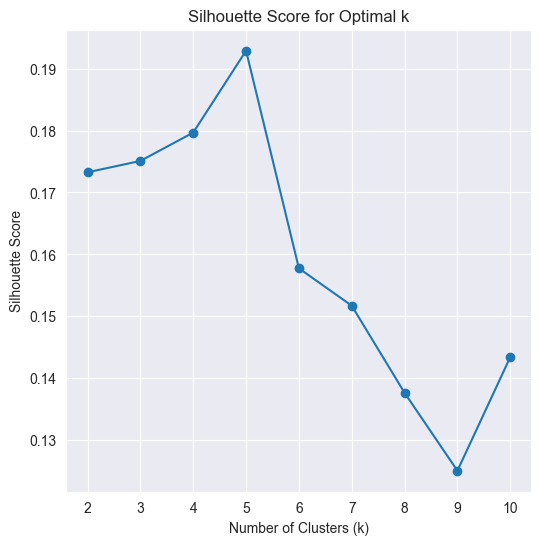

In [8]:
#Plotting silhouette score
silhouette_scores = []

#Exploring a range of k values
for k in range(2, 11):  # Silhouette Score is undefined for k=1
    kmeans = KMeans(n_clusters=k, random_state=8, init='k-means++', n_init=10, max_iter=300)
    kmeans.fit(X_scaled_mm)
    silhouette_avg = silhouette_score(X_scaled_mm, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

#Plotting silhouette scores
plt.figure(figsize=(6, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

I will use this model as a baseline. The silhouette score is low and needs improving. The number of clusters seems reasonable.

### KMeans v2

In [9]:
#Scaling using StandardScaler before feature reduction with VIF and PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_selection)

#Storing in a df for later use
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_selection.columns)

In [10]:
#Using VIF to reduce features
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif.sort_values(by="VIF", ascending=False)

#Initial VIF check
vif_df = calculate_vif(X_scaled_df)

#loop to drop features with VIF > 50
high_vif_threshold = 50
while vif_df["VIF"].max() > high_vif_threshold:
    feature_to_drop = vif_df.iloc[0]["Feature"]
    print(f"Dropping '{feature_to_drop}' with VIF = {vif_df.iloc[0]['VIF']:.2f}")
    X_scaled_df = X_scaled_df.drop(columns=feature_to_drop)
    vif_df = calculate_vif(X_scaled_df)

#Final set of features
X_reduced = X_scaled_df.copy()

In [11]:
#Checking the number of features
X_reduced.shape

(216, 10)

VIF has not reduced the number of features. They remain at 10.
I will now apply PCA for feature reduction and plotting.

In [12]:
#Applying PCA for further reduction
#keep enough components to explain 90% of variance
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_reduced)

# Print information about components
print(f"Number of components kept: {pca.n_components_}")
print(f"Total explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")


Number of components kept: 6
Total explained variance ratio: 0.936


PCA reduces features from 10 to 6 whilst retaining 94% of the variance in the data. This is very reasonable.

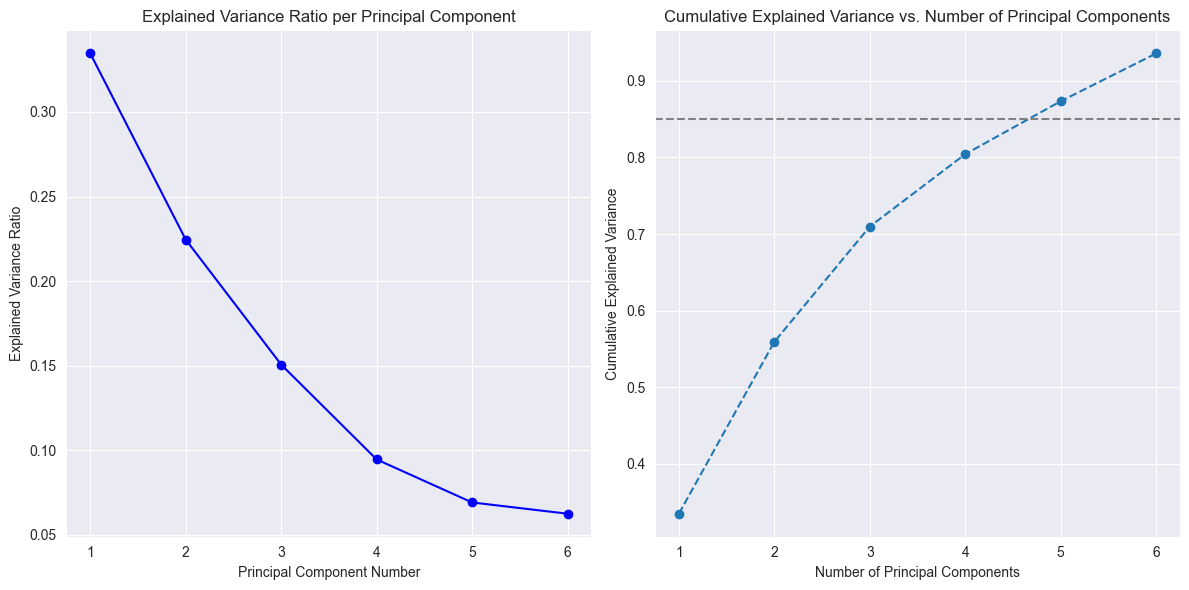

In [13]:
#Visualising the optimal number of components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#Plotting the explained variance ratio
ax1.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-')
ax1.set_xticks(range(1, len(pca.explained_variance_ratio_) + 1))
ax1.set_xlabel('Principal Component Number')
ax1.set_ylabel('Explained Variance Ratio')
ax1.grid(True)
ax1.set_title('Explained Variance Ratio per Principal Component')


#Plotting cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
ax2.set_title('Cumulative Explained Variance vs. Number of Principal Components')
ax2.set_xlabel('Number of Principal Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.axhline(y=0.850, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

Two components are able to explain c.58% of the variance in the data. I will plot these to inspect the results further.

In [14]:
#KMeans using PCA
#Use all components for clustering
k_values_pca = range(2, 11)
silhouette_scores = []

for k in k_values_pca:
    kmeans_pca = KMeans(n_clusters=k, random_state=8, init='k-means++', n_init=10, max_iter=300)
    cluster_labels = kmeans_pca.fit_predict(X_pca)  # Use all components
    silhouette_scores.append(silhouette_score(X_pca, cluster_labels))

# Finding optimal k using silhouette score
optimal_k = k_values_pca[np.argmax(silhouette_scores)]
print(f"Optimal K: {optimal_k}")


Optimal K: 2


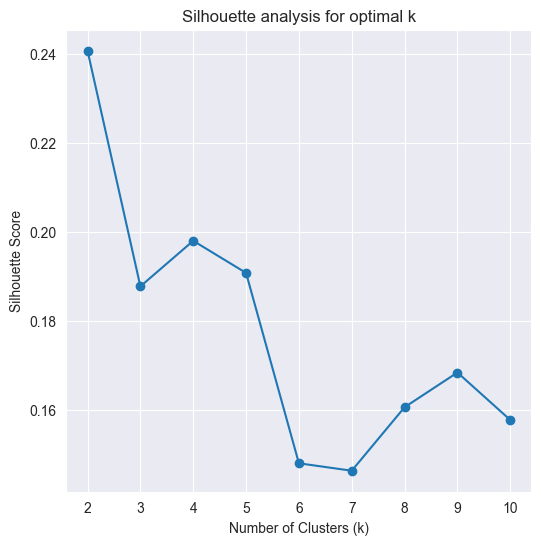

In [15]:
#Plotting silhouette scores to visualise optimal k
plt.figure(figsize=(6, 6))

plt.plot(k_values_pca, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette analysis for optimal k')
plt.show()

After feature reduction, we are seeing an optimal number of clusters of 2 (down from 5). This seems low given the potential variety of striker profiles.

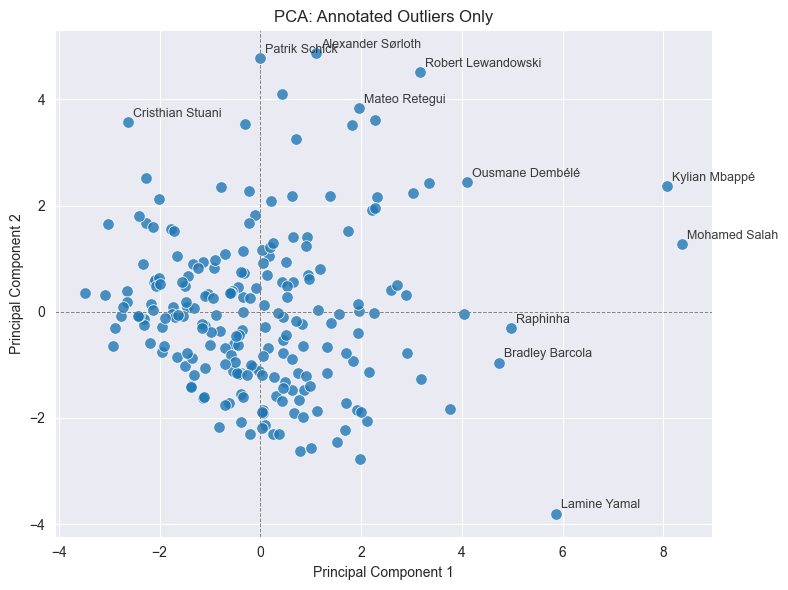

In [16]:
#Plotting outliers to see if my theory holds true
#Calculate Euclidean distance from the origin (0, 0)
distances = np.sqrt(X_pca[:, 0]**2 + X_pca[:, 1]**2)

#Define the threshold for "outlier" — top 5% of distances
threshold = np.percentile(distances, 95)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], s=70, alpha=0.8)

# Annotate only players beyond the threshold
for i, dist in enumerate(distances):
    if dist > threshold:
        plt.text(X_pca[i, 0] + 0.1, X_pca[i, 1] + 0.1, df.iloc[i]['name'],
                 fontsize=9, alpha=0.9)

plt.title('PCA: Annotated Outliers Only')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)
plt.grid(True)
plt.tight_layout()
plt.show()


The silhouette score improved after applying feature reduction methods (0.24), and the outliers in the plot are represented by elite players who also showed up in EDA. However, the groupings could be better. I will explore another model to find improvement.

Check out notebook 04 hdbscan for the final model and results.